## Create Rasterized Datasets

In [8]:
import pandas as pd
import numpy as nmp # it's called nmp so we can not confused it with np
import zarr

def in_cylinder(end_1, end_2, radius):
    # code borrowed from https://stackoverflow.com/questions/56463412/distance-from-a-point-to-a-line-segment-in-3d-python
    # getting the normalized tangent vector between the points
    d = nmp.divide(end_2 - end_1, nmp.linalg.norm(end_2 - end_1)) 

    # finding min and max to get all possible voxels that can fit inside the hypothetical cylinder there
    mins = nmp.floor(nmp.minimum(end_1,end_2)).astype(int)-(nmp.ceil(radius).astype(int)+1) #1s for padding
    maxs = nmp.ceil(nmp.maximum(end_1,end_2)).astype(int) +(nmp.ceil(radius).astype(int)+1)
    
    # now we get list of all the possible points using the mins and maxes (in form of x, y, z)
    x,y,z = [list(range(mins[i],maxs[i]+1,1)) for i in range(3)]
    p = nmp.array(nmp.meshgrid(x, y,z)).T.reshape((-1,3)) # puts together all the combinations of x y and z to actually get all possible points

    # signed parallel distance components
    # makes sure points aren't out of range of end points
    # dot product creates 2 parallel lines from the end points, so limits search to points between those lines (aka within end points)
    # negative dot product = between the two values
    # positive dot product = not between the values, so we toss those
    s = nmp.dot(end_1 - p, d) # the dot product of endpt 1 - point p (so a vector from endpt1 to p)
    t = nmp.dot(p - end_2, d) # the dot product of point p - endpt 2 (so a vector from endpt2 to p)

    # clamped parallel distance
    # now thats its limited to between end points, checks if the point is within the cylinder's radius
    # calculates distance from p to the center of cylinder
    # if distance < radius that we want, then voxel is inside np
    h = nmp.maximum.reduce([s, t, nmp.zeros_like(s)])
    # perpendicular distance component
    c = nmp.linalg.norm(nmp.cross(p - end_1, d),axis=1)
    
    # so if the conditions are right, then we know the voxel is inside the cylinder!
    is_in_cylinder = (h==0) & (c<=radius)
    return set(map(tuple, p[is_in_cylinder]))


### coding sequence actually begins here ###
# opens file with the np annotation data
zarr_file = zarr.open(f"/nrs/cellmap/data/jrc_mus-liver-zon-1/jrc_mus-liver-zon-1.n5", mode="r")
dataset = "em/fibsem-uint8/s0"
resolution = nmp.array(zarr_file[dataset].attrs.asdict()["transform"]["scale"]) # either 4x4x4 nm or 8x8x8 nm

# https://cell-map.slack.com/archives/C04N9JUFQK1/p1683733456153269
df = pd.read_csv("annotations_20230606_155330.csv")
np_starts = nmp.array([df["start x (nm)"], df["start y (nm)"], df["start z (nm)"]]).T/resolution # getting start points data in voxels (divide by res)
np_ends = nmp.array([df["end x (nm)"], df["end y (nm)"], df["end z (nm)"]]).T/resolution # getting end points data in voxels (divide by res)
np_centers = list(map(tuple,nmp.round(((np_starts+np_ends)*resolution/2)).astype(int))) # calculate centers (in nm)

# densely annotated validation region:
offset = nmp.array([11020, 9900, 7750]) # where validation region is located
dimensions = nmp.array([100, 150, 210]) # how big the validation space is

Now that we can find which points are in cylinder, we can do this for all annotations and concatenate, then we can write out the n5 file

In [9]:

from tqdm import tqdm
from numcodecs.gzip import GZip
import zarr

# get all np voxels and all overlapping/intersecting voxels between multiple np. np = nuclear pore, not to be confused with nmp numpy
all_np_voxels_set = set()
intersection_voxels_set = set()
for np_start,np_end in tqdm(zip(np_starts,np_ends),total=len(np_starts)):
    #goes thru each cylinder and adds voxels in current cylinder to all_np
    voxels_in_cylinder = in_cylinder(np_start,np_end,radius=7.5)
    #then look thru and see if there are any of them already in all_np (if so, they are intersecting) 
    intersection_voxels_set.update(all_np_voxels_set.intersection(voxels_in_cylinder))
    all_np_voxels_set.update(voxels_in_cylinder)

# repeat but now will write out the relevant voxels with appropriate np id (do not count intersecting ones aka remove overlap)
store = zarr.N5Store("/nrs/cellmap/nguyenh3/cellmap/np_preprocess/jrc_mus-liver-zon-1.n5")
# creating dataset
zarr_root = zarr.group(store=store)
ds = zarr_root.create_dataset(
        overwrite=True,
        name="nuclearpores_as_cylinders",
        dtype='u2', #unsigned int 2 bytes
        shape=zarr_file[dataset].shape, #dimensions of shape
        chunks=128, # size of chunk in each dimension (we like powers of 2) we also like it moderately small ~100
        write_empty_chunks=False, #if chunk of data (where u chunk it in x/y/z) doesnt contain anything, then this won't write it out
        compressor=GZip(level=6), #standard
    )

# attributes of the dataset
attributes = ds.attrs 
attributes["pixelResolution"] = { #set pixel res
    "dimensions": 3 * [8],
    "unit": "nm",
}

np_id = 1 #to number each one
all_np_voxels_set -= intersection_voxels_set # get rid of all the intersecting ones
# now we do what we did earlier (see how many voxels in the cylinder and subtract intersecting ones)
for np_start,np_end in tqdm(zip(np_starts,np_ends),total=len(np_starts)):
    voxels_in_cylinder = in_cylinder(np_start,np_end,radius=7.5) - intersection_voxels_set # get voxels in the cylinder minus intersecting ones
    if len(voxels_in_cylinder)>0:
        voxels_in_cylinder = nmp.array(list(voxels_in_cylinder)) # list of all voxels in the cylinder
        ds[voxels_in_cylinder[:,2],voxels_in_cylinder[:,1],voxels_in_cylinder[:,0]] = np_id # write out data to actual n5 data file
        np_id +=1 #increment ID when going to next np 
    else:
        raise Exception(f"Empty nuclear pore {np_starts}-{np_ends}")


100%|██████████| 243/243 [00:49<00:00,  4.93it/s]


After removing intersections from data, network needs to know it shouldnt train there, so set intersection voxels to 0. The mask is where we don't want network to train (1 everywhere else, 0 where there are intersecting voxels)

In [13]:
import os

# Use the same path and make/open the masks zarr file
#zarr_file = zarr.open(f"/nrs/cellmap/nguyenh3/cellmap/np_preprocess/jrc_mus-liver-zon-1/jrc_mus-liver-zon-1.n5", mode="r")
zarr_path = "/nrs/cellmap/nguyenh3/cellmap/np_preprocess/masks.zarr"
if not os.path.exists(zarr_path):
    zarr_root = zarr.open(zarr_path, mode='w')
# creating dataset for the mask
ds = zarr_root.create_dataset(
        overwrite=True,
        name="jrc_mus-liver-zon-1",
        dtype='u1',
        fill_value = 1, # we can set fill w/ zarr. with mask we want everything to be 1 so fill with 1 automatically 
        shape=zarr_file[dataset].shape,
        chunks=128, 
        write_empty_chunks=False,
        compressor=GZip(level=6),
    )
attributes = ds.attrs
attributes["pixelResolution"] = {
    "dimensions": 3 * [8],
    "unit": "nm",
}

# 
intersection_voxels = nmp.array(list(intersection_voxels_set))
ds[intersection_voxels[:,2],intersection_voxels[:,1],intersection_voxels[:,0]] = 0

## validation crop

In [14]:
from numcodecs.gzip import GZip

# taking the NP data set as cylinders and cropping it so we take a portion of the data for validation
zarr_file = zarr.open(f"/nrs/cellmap/nguyenh3/cellmap/np_preprocess/jrc_mus-liver-zon-1.n5", mode="r")
nuclearpores_as_cylinders = zarr_file["nuclearpores_as_cylinders"]
validation_crop = nuclearpores_as_cylinders[offset[2]:offset[2]+dimensions[2],
                                             offset[1]:offset[1]+dimensions[1],
                                             offset[0]:offset[0]+dimensions[0]]

store = zarr.N5Store("/nrs/cellmap/nguyenh3/cellmap/np_preprocess/jrc_mus-liver-zon-1.n5")
zarr_root = zarr.group(store=store)
ds = zarr_root.create_dataset(
        overwrite=True,
        name="validation_crop",
        data=validation_crop,
        dtype='u2',
        chunks=128,
        write_empty_chunks=False,
        compressor=GZip(level=6),
    )
attributes = ds.attrs
attributes["pixelResolution"] = {
    "dimensions": 3 * [8],
    "unit": "nm",
}
attributes["offset"] = list(offset)

get nuclear pores that are not in validation crop

In [18]:
# getting all training data set
updated_np_centers = []
removed_centers = []
# loop over all nuclear pores (sees which voxels are inside it) then checks if its in val crop,
# if they are then ignores it
for np_start,np_end,np_center in tqdm(zip(np_starts,np_ends,np_centers),total=len(np_starts)):
    voxels_in_cylinder = in_cylinder(np_start,np_end,radius=7.5)
    voxels_in_cylinder = nmp.array(list(voxels_in_cylinder))
    if ~nmp.any([(voxels_in_cylinder[:,0]>=offset[0]) & (voxels_in_cylinder[:,0]<=offset[0]+dimensions[0])
                & (voxels_in_cylinder[:,1]>=offset[1]) & (voxels_in_cylinder[:,1]<=offset[1]+dimensions[1])
                & (voxels_in_cylinder[:,2]>=offset[2]) & (voxels_in_cylinder[:,2]<=offset[2]+dimensions[2])]):
        updated_np_centers.append(np_center)
    else:
        removed_centers.append(np_center)
len(updated_np_centers),len(np_centers)

100%|██████████| 243/243 [00:00<00:00, 402.99it/s]


(216, 243)

stopped before here 6/6/23
rather than have training centered exactly at nuclear pore centers, use the centers as a reference for choosing a random location:

In [20]:
# makes sure center is not part of validation set
def center_is_valid(center, edge_length):
    if nmp.all( (center+edge_length) >= offset) and nmp.all( (center-edge_length) <= (offset+dimensions) ):
        # then it overlaps validation
        return False
    return True

# checks so that 
def too_close_to_validation(np_start, np_end, edge_length):
    # either the start or end will be furthest from the box
    start_distance = nmp.linalg.norm( nmp.maximum.reduce([offset - np_start, nmp.zeros_like(np_start), np_start-(offset+dimensions)]) )
    end_distance = nmp.linalg.norm( nmp.maximum.reduce([offset - np_end, nmp.zeros_like(np_end), np_end-(offset+dimensions)]) )
    return nmp.maximum(start_distance, end_distance) <= edge_length

# shifts everything so we can grab more context
pseudorandom_training_centers = []
for np_start,np_end in tqdm(zip(np_starts,np_ends),total=len(np_starts)):
    # ultimately seems to predict on 36x36x36 region, so we need to make sure this doesn't overlap with validation
    # lets just shift by at most +/-10 in any dimension for the center to help ensure that a non-neglible part of the rasterization, and original annotation, are included in a box centered at that region
    max_shift = 18
    edge_length = 18+1 # add one for padding since we round later down
    # first find a random coordinate along the annotation. this will be included within the box

    # now find a valid center
    if not too_close_to_validation(np_start,np_end, edge_length):
        random_coordinate_along_annotation = np_start+(np_end-np_start)*nmp.random.rand()
        center = random_coordinate_along_annotation + nmp.random.randint(low=-max_shift,high=max_shift,size=3)
        while not center_is_valid(center, edge_length):
            random_coordinate_along_annotation = np_start+(np_end-np_start)*nmp.random.rand()
            center = random_coordinate_along_annotation + nmp.random.randint(low=-max_shift,high=max_shift,size=3)
        pseudorandom_training_centers.append(tuple(nmp.round(center*resolution).astype(int)))
    else:
        c = nmp.round(((np_start+np_end)*resolution/2)).astype(int)
        if tuple(c) not in removed_centers:
            print(np_start,np_end)
len(pseudorandom_training_centers),len(np_starts)

100%|██████████| 243/243 [00:00<00:00, 10640.33it/s]

[11046.6796875  10060.16503906  7802.078125  ] [11043.390625  10059.1640625  7799.421875 ]
[11045.03808594 10024.30273438  7975.15625   ] [11040.4609375  10025.68652344  7975.85058594]
[11070.54101562 10056.00390625  7735.15234375] [11066.54101562 10056.00292969  7735.15234375]
[11105.37109375  9892.10546875  7889.21044922] [11102.01757812  9889.75878906  7890.49511719]
[11134.03417969  9909.51757812  7738.98876953] [11130.5234375   9908.24414063  7738.65820312]
[11133.42871094  9893.18359375  7756.02392578] [11136.97363281  9893.97558594  7757.34375   ]
[11097.71582031  9890.43847656  7964.86523438] [11101.05371094  9893.02636719  7963.08740234]
[11105.91113281  9890.109375    7926.36230469] [11102.61035156  9883.04003906  7929.12988281]


(208, 243)

Random testing is below

In [10]:
random_coordinate_along_annotation = NP_start+(NP_end-NP_start)*np.random.rand()
np.mean(np.linalg.norm((NP_starts[:50]+NP_ends[:50])/2-np.array(pseudorandom_training_centers[:50])/8,axis=1))

18.88449745048757

In [11]:
np.array(updated_NP_centers[5])/8,np.array(pseudorandom_training_centers[5])/8

(array([11225.375, 10457.5  ,  7514.75 ]),
 array([11238.5  , 10461.125,  7506.25 ]))

In [12]:
random_coordinate_along_annotation
NP_start+(NP_end-NP_start)*np.random.rand()
print(random_coordinate_along_annotation, NP_start, NP_end, random_coordinate_along_annotation + np.random.randint(low=-max_shift,high=max_shift,size=3))

[11283.93419863  9680.29622955  7965.96543411] [11290.10449219  9681.64941406  7966.13183594] [11282.69921875  9680.02539062  7965.93212891] [11291.93419863  9693.29622955  7966.96543411]


In [13]:
NP_centers[-1]/resolution,pseudorandom_training_centers[-1]/resolution

(array([11286.375,  9680.875,  7966.   ]), array([11297. ,  9684.5,  7955. ]))

In [14]:
(NP_start>0) and (NP_end>0)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

# Dacapo

In [9]:
from dacapo.experiments.architectures import CNNectomeUNetConfig
from dacapo.experiments.trainers import GunpowderTrainerConfig
from dacapo.experiments.trainers.gp_augments import ElasticAugmentConfig,IntensityAugmentConfig
from dacapo.experiments.tasks import AffinitiesTaskConfig
from funlib.geometry.coordinate import Coordinate
import math

## Trainer

In [8]:
# dacapo -> makes it easier to use pytorch

trainer_config = GunpowderTrainerConfig(
        name="default_v2",
        batch_size=2,#how many it takes in at once before updating
        learning_rate=0.0001, 
        augments=[ #augments add more variation so it can learn more different things (makes more generic)
            ElasticAugmentConfig(
                control_point_spacing=(100, 100, 100),
                control_point_displacement_sigma=(10.0, 10.0, 10.0),
                rotation_interval=(0, math.pi / 2.0),
                subsample=8,
                uniform_3d_rotation=True,
            ),
            IntensityAugmentConfig(
                scale=(0.7, 1.3),
                shift=(-0.2, 0.2),
                clip=True,
            ),
        ],
        clip_raw=True,
        num_data_fetchers=20,
        snapshot_interval=10000,
        min_masked=0.05,
    )

## Task

In [10]:
task_config = AffinitiesTaskConfig(

    # task that we want is to predict affinities
    # 19 total predicted channels
    # 9 neighborhood channels + 10 local shape descriptors
    # idk where the local shape descriptors are but its not here
    # higher affinity = i think i am connected to that voxel to the one space z from me (1, 0, 0) = 2. the same thing with the others but 3 or 9 
    # voxels away from me
    # neighborhood 
            name=f"3d_lsdaffs",
            neighborhood=[
                (1, 0, 0),
                (0, 1, 0),
                (0, 0, 1),
                (3, 0, 0),
                (0, 3, 0),
                (0, 0, 3),
                (9, 0, 0),
                (0, 9, 0),
                (0, 0, 9),
            ],
            lsds=True, # do the lsds task (local shape descriptors)
        )

## Architecture

I had an issue where, by default, I created the rasterization at the same resolution as the raw data. But the default architecture (with the upsampling layer `upsample_factors`) expects it to be at 2x the resolution including mask and validation. This resulted in an error when submitting. Since we don't really care about a higher res (at the moment), we can just comment out the upsampling layer (`constant_upsample` and `upsample_factors`)

In [10]:
architecture_config = CNNectomeUNetConfig( #here is the actual network architecture (a u-net) the cnnectome
        name="upsample-unet",
        input_shape=Coordinate(216, 216, 216), # size/shape of input 
        eval_shape_increase=Coordinate(72, 72, 72),
        fmaps_in=1,
        num_fmaps=12,
        fmaps_out=72,
        fmap_inc_factor=6,
        downsample_factors=[(2, 2, 2), (3, 3, 3), (3, 3, 3)], # in addition to convolutional layers, also down samples to make it smaller 
        # and then gets bigger later when upsampling
        #constant_upsample=True,
        #upsample_factors=[(2, 2, 2)],
    )

## Datasplit

EVERYTHING MUST BE IN Z,Y,X AND NM!

In [129]:
# use centers
from pathlib import Path
from dacapo.experiments.datasplits.datasets.arrays import (
    ZarrArrayConfig,
    IntensitiesArrayConfig,
    CropArrayConfig,
)
from dacapo.experiments.datasplits.datasets import RawGTDatasetConfig
from dacapo.experiments.datasplits import TrainValidateDataSplitConfig
from funlib.geometry import Roi

# lets look at raw data (input for network)
raw_config = ZarrArrayConfig(
    name = "raw",
    file_name=Path("/nrs/stern/em_data/jrc_22ak351-leaf-3m/jrc_22ak351-leaf-3m.n5"),
    dataset="em/fibsem-uint8/s0",
)

# everything is rescaled between 0 and 1, just makes sure u set everytnhing in place with mins/maxes
# We get an error without this, and will suggests having it as such https://cell-map.slack.com/archives/D02KBQ990ER/p1683762491204909
raw_config = IntensitiesArrayConfig(name="raw", source_array_config = raw_config, min=0, max=255)

# ground truth = actual data annotated
gt_config = ZarrArrayConfig(
    name="nuclearpores", 
    file_name=Path("/nrs/cellmap/ackermand/cellmap/leaf-gall/jrc_22ak351-leaf-3m.n5"), 
    dataset="nuclearpores_as_cylinders"
)

# mask out regions of overlapping nuclear pores
# 
mask_config = ZarrArrayConfig(
    name="mask", 
    file_name=Path("/nrs/cellmap/ackermand/cellmap/leaf-gall/masks.zarr"), 
    dataset="jrc_22ak351-leaf-3m"
)

# could do validation as a file
# val_gt_config = ZarrArrayConfig(
#     name="nuclearpores", file_name="/path/to/data.zarr", dataset="labels_val"
# )

# NOTE: Everything has to be in z,y,x cries
# multiply by resolution to go from nm to pixels
validation_roi = Roi(offset[::-1]*resolution, dimensions[::-1]*resolution)
val_gt_config = CropArrayConfig(
    "val_gt", source_array_config=gt_config, roi=validation_roi
    # the ground truth config same as source for val
    # we just are specifying the region of interest (roi)
    # has the offset and dimensions
    # instead of writing out the crop (we did it anyway) just pass in region of interest corresponding with val region
    # the only reason we wrote out the crop earlier is to visualize easier
)

# now training data has raw data, unwanted stuff is masked, coordinates of the centers as the sample pts
training_data_config = RawGTDatasetConfig(
    "train",
    raw_config = raw_config,
    gt_config = gt_config,
    sample_points = [Coordinate(NP_center[::-1]) for NP_center in updated_NP_centers],#[Coordinate((29229*8,1862*8,7439*8))], #
    mask_config = mask_config
)

# same with val data config (pass in the val config) only difference is we specific the ROI for val data
validation_data_config = RawGTDatasetConfig("val", raw_config = raw_config, gt_config=val_gt_config, mask_config=mask_config)

# finally specifying which one is the train and which is the validating data set
datasplit_config = TrainValidateDataSplitConfig(
    name="nuclearpores", train_configs=[training_data_config], validate_configs=[validation_data_config]
)

In [11]:
# use pseudorandom centers
# same thing just using different centers

from pathlib import Path
from dacapo.experiments.datasplits.datasets.arrays import (
    ZarrArrayConfig,
    IntensitiesArrayConfig,
    CropArrayConfig,
)
from dacapo.experiments.datasplits.datasets import RawGTDatasetConfig
from dacapo.experiments.datasplits import TrainValidateDataSplitConfig
from funlib.geometry import Roi

raw_config = ZarrArrayConfig(
    name = "raw",
    file_name=Path("/nrs/stern/em_data/jrc_22ak351-leaf-3m/jrc_22ak351-leaf-3m.n5"),
    dataset="em/fibsem-uint8/s0",
)
# We get an error without this, and will suggests having it as such https://cell-map.slack.com/archives/D02KBQ990ER/p1683762491204909
raw_config = IntensitiesArrayConfig(name="raw", source_array_config = raw_config, min=0, max=255)

gt_config = ZarrArrayConfig(
    name="nuclearpores", 
    file_name=Path("/nrs/cellmap/ackermand/cellmap/leaf-gall/jrc_22ak351-leaf-3m.n5"), 
    dataset="nuclearpores_as_cylinders"
)

# mask out regions of overlapping nuclear pores
mask_config = ZarrArrayConfig(
    name="mask", 
    file_name=Path("/nrs/cellmap/ackermand/cellmap/leaf-gall/masks.zarr"), 
    dataset="jrc_22ak351-leaf-3m"
)

# could do validation as a file
# val_gt_config = ZarrArrayConfig(
#     name="nuclearpores", file_name="/path/to/data.zarr", dataset="labels_val"
# )

# NOTE: Everything has to be in z,y,x
validation_roi = Roi(offset[::-1]*resolution, dimensions[::-1]*resolution)
val_gt_config = CropArrayConfig(
    "val_gt", source_array_config=gt_config, roi=validation_roi
)
training_data_config = RawGTDatasetConfig(
    f"train_pseudorandom_training_centers_maxshift_{max_shift}",
    raw_config = raw_config,
    gt_config = gt_config,
    sample_points = [Coordinate(pseudorandom_training_center[::-1]) for pseudorandom_training_center in pseudorandom_training_centers],#[Coordinate((29229*8,1862*8,7439*8))], #
    mask_config = mask_config
)
validation_data_config = RawGTDatasetConfig("val", raw_config = raw_config, gt_config=val_gt_config, mask_config=mask_config)
datasplit_config = TrainValidateDataSplitConfig(
    name=f"nuclearpores_pseudorandom_training_centers_maxshift_{max_shift}", train_configs=[training_data_config], validate_configs=[validation_data_config]
)

## Run

In [133]:
from dacapo.experiments import RunConfig
from dacapo.experiments.starts import StartConfig
from dacapo.store.create_store import create_config_store
config_store = create_config_store()

start_config = StartConfig("setup04", "best") # using a pretrained set (called best) and just fine tuning the weights from there
iterations = 200000
validation_interval = 5000 # every 5000, validate and check how its doing and update
repetitions = 2 # do the validation twice wch time
for i in range(repetitions): #NOTE: Here I am redoing with 2 and 3 becuase i think something happened with validation since i didnt reset the validation scores. ultimately this would probably be fine since eventually lower scores would be reached, but initiailly is giving weird results
    run_config = RunConfig( # this is what we actualaly running on the cluster
        name=("_").join(
            [
                "scratch" if start_config is None else "finetuned",
                task_config.name, # with the afinitiies
                datasplit_config.name, # all the data sets we split (val and train)
                architecture_config.name, # UNET arch
                trainer_config.name, # the trainer
            ]
        )
        + f"__test_{i}",
        task_config=task_config,
        datasplit_config=datasplit_config,
        architecture_config=architecture_config,
        trainer_config=trainer_config,
        num_iterations=iterations,
        validation_interval=validation_interval,
        repetition=i,
        start_config=start_config,
    )
    config_store.store_run_config(run_config)
#"dacapo run -r {run_config.name}"

In [8]:
offset*8

array([219200,  16000,  42400])

In [21]:
run_config.name

'finetuned_3d_lsdaffs_plasmodesmata_upsample-unet_default_v2__1'

Visualize run before train: https://github.com/janelia-cellmap/ml_experiments/blob/main/scripts/visualize_pipeline.py
creates a neuroglancer view, of your training samples. hitting "t" refreshes to a new example

python ~/Programming/ml_experiments/scripts/visualize_pipeline.py visualize-pipeline -r finetuned_3d_lsdaffs_nuclearpores_upsample-unet_default_v2__1

for now i manually created a file in ~/Programming/ml_experiments/configs/cellmap/runs/NP_test/runs.yaml which contains the run names then i changed to the ml_experiments directory and activate the `cellmap_experiments` dir. then i ran `python scripts/submit.py run -r configs/cellmap/runs/NP_test/runs.yaml -b cellmap -q gpu_t4 -n 10`. 

## Important Note

Had to change to `affs.astype(np.float64)` in line 49 /groups/scicompsoft/home/ackermand/Programming/dacapo/dacapo/experiments/tasks/post_processors/watershed_post_processor.py", line 48, in process

otherwise got this error:
TypeError: argument 'affinities': type mismatch:
 from=float32, to=float64

also had to add flattening and reshapping during remap in line 69 in same file:
`segmentation = npi.remap(segmentation.flatten(), filtered_fragments, replace).reshape(segmentation.shape)`

otherwise got error:
TypeError: '<' not supported between instances of 'int' and 'bytes'

Also had to change a lot in `/groups/scicompsoft/home/ackermand/Programming/dacapo/dacapo/validate.py` and `/groups/scicompsoft/home/ackermand/Programming/dacapo/dacapo/evaluate.py` because previously it would determine the best validation trial as being when a parameter setting produced better results than its previous best. This means that even if parameter_id = 0 was bad, as long as it was better than parameter_id=0 from all previous validations, then it would overwrite the best. I changed it so that the overall best for the metric, eg. `voi` is calculated first, and the best validation set is only overwritten if it is the overall best.

In [27]:
from numcodecs.gzip import GZip
import zarr

store = zarr.N5Store("./test.n5")
zarr_root = zarr.group(store=store)
ds = zarr_root.create_dataset(
        overwrite=True,
        name="test",
        dtype='u1',
        shape=zarr_file[dataset].shape,
        chunks=128,
        write_empty_chunks=False,
        compressor=GZip(level=6),
    )
attributes = ds.attrs
attributes["pixelResolution"] = {
    "dimensions": 3 * [8],
    "unit": "nm",
}

In [25]:
import pickle
import numpy_indexed as npi
import numpy as np
from numpy_indexed.funcs import *
from numpy_indexed.index import *
from builtins import *
from numpy_indexed.arraysetops import indices

with open('remap.pkl', 'rb') as f:
    segmentation, filtered_fragments, replace = pickle.load(f)
    input=segmentation
    keys = filtered_fragments
    values = replace
#idx = indices(keys, input.flatten(), missing='mask')
segmentation = npi.remap(segmentation, keys, values).reshape(segmentation.shape)

TypeError: '<' not supported between instances of 'int' and 'bytes'

## Prediction

1. symlink to default directory `/nrs/cellmap/data/` as seen in `ml_experiments/configs/yamls/constants.yaml`
2. add `nuclearpores` to `ml_experiments/configs/yamls/targets/instance_seg.yaml`
3. copy `ml_experiments/configs/cellmap/predictions/jrc_mu-liver-zon-1/2023-02-10.yaml` to `ml_experiments/configs/cellmap/predictions/NP_test/2023-05-17.yaml` and update accordingly.
4. Try to predict using this: `python scripts/submit.py predict -p configs/cellmap/predictions/NP_test/2023-05-17.yaml -w 60`, based on this region [this region](http://renderer.int.janelia.org:8080/ng/#!%7B%22dimensions%22:%7B%22x%22:%5B1e-9%2C%22m%22%5D%2C%22y%22:%5B1e-9%2C%22m%22%5D%2C%22z%22:%5B1e-9%2C%22m%22%5D%7D%2C%22position%22:%5B228016.65625%2C14467.8486328125%2C58427.31640625%5D%2C%22crossSectionOrientation%22:%5B0%2C1%2C0%2C0%5D%2C%22crossSectionScale%22:9.803848825583122%2C%22projectionOrientation%22:%5B-0.33944520354270935%2C-0.9385530948638916%2C-0.019331367686390877%2C-0.05934092774987221%5D%2C%22projectionScale%22:6636.598844056%2C%22layers%22:%5B%7B%22type%22:%22image%22%2C%22source%22:%22n5://http://renderer.int.janelia.org:8080/n5_sources/stern/jrc_22ak351-leaf-3m.n5/em/fibsem-uint8%22%2C%22tab%22:%22source%22%2C%22shaderControls%22:%7B%22normalized%22:%7B%22range%22:%5B40%2C140%5D%7D%7D%2C%22crossSectionRenderScale%22:0.12964438055577399%2C%22name%22:%22fibsem-uint8%22%7D%2C%7B%22type%22:%22segmentation%22%2C%22source%22:%5B%22n5://http://cellmap-vm1.int.janelia.org/nrs/ackermand/cellmap/leaf-gall/jrc_22ak351-leaf-3m.n5/plasmodesmata_column_cells/%22%2C%22precomputed://http://cellmap-vm1.int.janelia.org/nrs/ackermand/meshes/multiresolution/leaf-gall/jrc_22ak351-leaf-3m/plasmodesmata_column_cells/multires%22%5D%2C%22tab%22:%22segments%22%2C%22selectedAlpha%22:0.43%2C%22meshSilhouetteRendering%22:2.6%2C%22segmentDefaultColor%22:%22#9900ff%22%2C%22name%22:%22plasmodesmata_column_cells%22%2C%22visible%22:false%7D%2C%7B%22type%22:%22segmentation%22%2C%22source%22:%5B%22n5://http://cellmap-vm1.int.janelia.org/nrs/ackermand/cellmap/leaf-gall/jrc_22ak351-leaf-3m.n5/plasmodesmata_column_target_cells%22%2C%22precomputed://http://cellmap-vm1.int.janelia.org/nrs/ackermand/meshes/multiresolution/leaf-gall/jrc_22ak351-leaf-3m/plasmodesmata_column_target_cells/multires%22%5D%2C%22tab%22:%22source%22%2C%22selectedAlpha%22:0.2%2C%22segmentDefaultColor%22:%22#1fffb4%22%2C%22name%22:%22plasmodesmata_column_target_cells%22%7D%2C%7B%22type%22:%22annotation%22%2C%22source%22:%7B%22url%22:%22local://annotations%22%2C%22transform%22:%7B%22outputDimensions%22:%7B%22x%22:%5B1e-9%2C%22m%22%5D%2C%22y%22:%5B1e-9%2C%22m%22%5D%2C%22z%22:%5B1e-9%2C%22m%22%5D%7D%2C%22inputDimensions%22:%7B%220%22:%5B8e-9%2C%22m%22%5D%2C%221%22:%5B8e-9%2C%22m%22%5D%2C%222%22:%5B8e-9%2C%22m%22%5D%7D%7D%7D%2C%22tool%22:%22annotateLine%22%2C%22tab%22:%22source%22%2C%22annotations%22:%5B%5D%2C%22shader%22:%22#uicontrol%20float%20lineWidth%20slider%28min=1%2C%20max=50%2C%20step=1%2C%20default=10%29%5Cn#uicontrol%20vec3%20color%20color%28default=%5C%22white%5C%22%29%5Cn%5Cnvoid%20main%28%29%20%7B%5Cn%20%20setLineWidth%28lineWidth%29%3B%5Cn%20%20setColor%28color%29%3B%5Cn%7D%5Cn%5Cn%22%2C%22shaderControls%22:%7B%22color%22:%22#ff0000%22%7D%2C%22name%22:%22annotations%22%7D%2C%7B%22type%22:%22annotation%22%2C%22source%22:%22precomputed://https://cellmap-vm1.int.janelia.org/dm11/ackermand/neuroglancer_annotations/20230510_114340%22%2C%22tab%22:%22source%22%2C%22annotationColor%22:%22#8b8b23%22%2C%22shader%22:%22#uicontrol%20float%20lineWidth%20slider%28min=1%2C%20max=50%2C%20step=1%2C%20default=10%29%5Cn#uicontrol%20vec3%20color%20color%28default=%5C%22white%5C%22%29%5Cn%5Cnvoid%20main%28%29%20%7B%5Cn%20%20setLineWidth%28lineWidth%29%3B%5Cn%20%20setColor%28color%29%3B%5Cn%7D%5Cn%5Cn%22%2C%22shaderControls%22:%7B%22color%22:%22#ff0000%22%7D%2C%22name%22:%22saved_annotations%22%7D%2C%7B%22type%22:%22segmentation%22%2C%22source%22:%7B%22url%22:%22n5://http://cellmap-vm1.int.janelia.org/nrs/ackermand/cellmap/leaf-gall/jrc_22ak351-leaf-3m.n5/validation_crop/%22%2C%22transform%22:%7B%22matrix%22:%5B%5B1%2C0%2C0%2C219200%5D%2C%5B0%2C1%2C0%2C16000%5D%2C%5B0%2C0%2C1%2C42400%5D%5D%2C%22outputDimensions%22:%7B%22x%22:%5B1e-9%2C%22m%22%5D%2C%22y%22:%5B1e-9%2C%22m%22%5D%2C%22z%22:%5B1e-9%2C%22m%22%5D%7D%7D%2C%22subsources%22:%7B%22default%22:true%2C%22bounds%22:true%7D%2C%22enableDefaultSubsources%22:false%7D%2C%22tab%22:%22source%22%2C%22name%22:%22validation_crop%22%7D%5D%2C%22showSlices%22:false%2C%22selectedLayer%22:%7B%22visible%22:true%2C%22layer%22:%22validation_crop%22%7D%2C%22layout%22:%224panel%22%2C%22statistics%22:%7B%22visible%22:true%7D%2C%22selection%22:%7B%22layers%22:%7B%22annotations%22:%7B%22annotationId%22:%22df5661d17178a2ccd1624582136e59c925677961%22%2C%22annotationSource%22:0%2C%22annotationSubsource%22:%22default%22%7D%7D%7D%7D)

Once we have lsds we need to do affinities

1. `python scripts/post_processing_david/02_extract_fragments_blockwise.py`
2. 

In [17]:
import yaml
from pathlib import Path
prediction_data = yaml.safe_load(Path("/groups/scicompsoft/home/ackermand/Programming/ml_experiments/configs/cellmap/predictions/pd_test/2023-05-17.yaml").open("r").read())
for matrix in prediction_data["predictions"]:
    offset, shape = matrix.get("roi", (None, None))
    print(offset,shape)

[1, 2, 3] [4, 5, 6]


# scratchspace

## watershed

In [4]:
import mwatershed
import numpy as  np
offsets = [(0, 1), (1, 0)]
affinities = (
    np.array(
        #[[[0, 1, 0], [0, 1, 0], [0, 1, 0]], 
        # [[0, 0, 0], [1, 1, 1], [0, 0, 0]]],
        [[[0, 0, 0], [0, 0, 0], [0, 0, 0]], 
        [[0, 0, 0], [0, 0, 0], [0, 0, 0]]],
        dtype=float,
    )
    - 0.5
)
# 9 nodes. connecting edges:
# 2-3, 5-6, 8-9, 4-7, 5-8, 6-9
# components: [(1,),(2,3),(4,7),(5,6,8,9)]

components = mwatershed.agglom(affinities, offsets)
print(affinities,components)

[[[-0.5 -0.5 -0.5]
  [-0.5 -0.5 -0.5]
  [-0.5 -0.5 -0.5]]

 [[-0.5 -0.5 -0.5]
  [-0.5 -0.5 -0.5]
  [-0.5 -0.5 -0.5]]] [[0 1 2]
 [3 4 5]
 [6 7 8]]


In [15]:
import mwatershed
offsets = [(0, 0, 1), (0, 1, 0), (1, 0, 0)]
affinities = (
    np.array(
        [
            [[[1, 0], [0, 0]], [[0, 0], [1, 0]]],
            [[[1, 0], [0, 0]], [[0, 1], [0, 0]]],
            [[[1, 0], [0, 1]], [[0, 0], [0, 0]]],
        ],
        dtype=float,
    )
    - 0.5
)
# 8 nodes. connecting edges:
# 1-2, 1-3, 1-7, 4-8, 6-8, 7-8
# components: [(1,2,3,7),(4,6,7,8)]

components = mwatershed.agglom(affinities, offsets)
print(components)
#assert set(np.unique(components)) == set([1, 4])


[[[1 1]
  [1 7]]

 [[1 7]
  [7 7]]]


In [2]:
from dacapo.predict import predict
from dacapo.compute_context import LocalTorch, ComputeContext
from dacapo.experiments import Run, ValidationIterationScores
from dacapo.experiments.datasplits.datasets.arrays import ZarrArray
from dacapo.store import (
    create_array_store,
    create_config_store,
    create_stats_store,
    create_weights_store,
)

import torch

from pathlib import Path
import logging

logger = logging.getLogger(__name__)
run_name = "finetuned_3d_lsdaffs_nuclearpores_upsample-unet_default_v2__0"

config_store = create_config_store()
run_config = config_store.retrieve_run_config(run_name)
run = Run(run_config)

# read in previous training/validation stats

stats_store = create_stats_store()
run.training_stats = stats_store.retrieve_training_stats(run_name)
run.validation_scores.scores = stats_store.retrieve_validation_iteration_scores(
    run_name
)

evaluator = run.task.evaluator
evaluator.set_best(run.validation_scores)

#weights_store = create_weights_store()
#print(weights_store.retrieve_best(run_name, "voi", "val"))

# Initialize the evaluator with the best scores seen so far
#evaluator.set_best(run.validation_scores)

from dacapo.experiments.tasks.evaluators import InstanceEvaluationScores
from dacapo.experiments.datasplits.datasets import Dataset

scores = InstanceEvaluationScores()
for dataset,_,_ in evaluator.best_scores.keys():
    break
overall_best_score = evaluator.get_overall_best(dataset, "voi_merge", scores)
print(overall_best_score)


	Missing key(s) in state_dict: "architecture.unet.l_conv.0.conv_pass.0.weight", "architecture.unet.l_conv.0.conv_pass.0.bias", "architecture.unet.l_conv.0.conv_pass.2.weight", "architecture.unet.l_conv.0.conv_pass.2.bias", "architecture.unet.l_conv.1.conv_pass.0.weight", "architecture.unet.l_conv.1.conv_pass.0.bias", "architecture.unet.l_conv.1.conv_pass.2.weight", "architecture.unet.l_conv.1.conv_pass.2.bias", "architecture.unet.l_conv.2.conv_pass.0.weight", "architecture.unet.l_conv.2.conv_pass.0.bias", "architecture.unet.l_conv.2.conv_pass.2.weight", "architecture.unet.l_conv.2.conv_pass.2.bias", "architecture.unet.l_conv.3.conv_pass.0.weight", "architecture.unet.l_conv.3.conv_pass.0.bias", "architecture.unet.l_conv.3.conv_pass.2.weight", "architecture.unet.l_conv.3.conv_pass.2.bias", "architecture.unet.r_up.0.0.up.1.weight", "architecture.unet.r_up.0.0.up.1.bias", "architecture.unet.r_up.0.1.up.1.weight", "architecture.unet.r_up.0.1.up.1.bias", "architecture.unet.r_up.0.2.up.1.weig

1.154080601777265


In [12]:
z = zarr.open('test.n5', mode='w')
z[1,2,3]=1


In [33]:
arr = np.zeros([128*3]*3)
starts = np.array([100.5,20,5])
ends = np.array([150,40.5,20])
radius = 3
index_iterable = np.ndindex(*arr.shape)


In [58]:
#p = np.indices(arr.shape).reshape((arr.size,3))

in_cylinder(p,a,b,r)

array([False, False, False, ..., False, False, False])

simplest way to generate the rasterized cylinders would be to open each annotation and writing out annotations in corresponding chunks, then we only have to do ~1900 iterations. and can just write out to appropriate chunks. can also read if the chunk already exists so we can write multiple annotations to same chunk

In [32]:
np.array(zarr_file[dataset].attrs.asdict()["blockSize"])

KeyError: 'blockSize'

In [53]:
zarr_file[dataset].shape

(11301, 6464, 32690)

Text(0.5, 0, 'Volume (nm^3)')

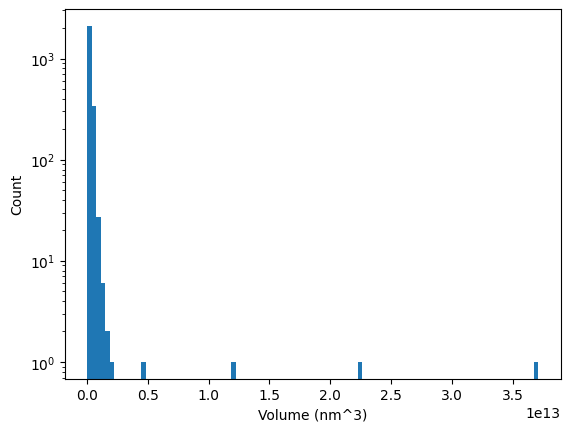

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv("/nrs/cellmap/ackermand/cellmap/analysisResults/jrc_mus-liver-zon-1/nucleus.csv")
plt.hist(df["Volume (nm^3)"],bins=100)
plt.semilogy()
plt.ylabel('Count')
plt.xlabel('Volume (nm^3)')

In [16]:
import numpy as np
np.sum(df["Volume (nm^3)"]>0.25e13)

4

In [3]:
import numpy_indexed as npi
import numpy as np
a=np.array([1,2],dtype=np.uint64)
b=np.array([1,2],dtype=np.uint64)
c=np.array([1,2],dtype=np.uint64)

print(npi.remap(a,b,c))
print(a.dtype,b.dtype,c.dtype)


[1 2]
uint64 uint64 uint64


In [5]:
import numpy as np
adjacent_edge_bias = -1
lr_edge_bias = 1
offsets = [
                (1, 0, 0),
                (0, 1, 0),
                (0, 0, 1),
                (3, 0, 0),
                (0, 3, 0),
                (0, 0, 3),
                (9, 0, 0),
                (0, 9, 0),
                (0, 0, 9),
            ]
shift = np.array(
    [adjacent_edge_bias if max(offset) <= 1 else lr_edge_bias for offset in offsets]
).reshape((-1, *((1,) * (len((3, 136, 136, 121)) - 1))))
shift

array([[[[-1]]],


       [[[-1]]],


       [[[-1]]],


       [[[ 1]]],


       [[[ 1]]],


       [[[ 1]]],


       [[[ 1]]],


       [[[ 1]]],


       [[[ 1]]]])

In [2]:
from dacapo.store.create_store import create_config_store,create_config_store,create_weights_store
from dacapo.experiments import Run

import daisy
from funlib.persistence import open_ds, prepare_ds
from funlib.geometry import Coordinate,Roi

import click
import numpy as np

import subprocess
import logging
from dacapo.predict import predict
from dacapo.store.local_array_store import LocalArrayIdentifier
from dacapo.compute_context import LocalTorch
from pathlib import Path
import torch
from dacapo.experiments.datasplits.datasets.arrays import ZarrArray
from dacapo.experiments.tasks.post_processors.watershed_post_processor_parameters import WatershedPostProcessorParameters


run_name = "finetuned_3d_lsdaffs_nuclearpores_upsample-unet_default_v2__0"
config_store = create_config_store()
run_config = config_store.retrieve_run_config(run_name)

config_store = create_config_store()
run_config = config_store.retrieve_run_config(run_name)
run = Run(run_config)

# create weights store and read weights
weights_store = create_weights_store()
weights = weights_store.retrieve_weights(run, 165000)
weights_store._load_best(run, "val/voi")
#run.model.load_state_dict(weights.model)

for validation_dataset in run.datasplit.validate:
    output_roi = validation_dataset.gt.roi
    model = run.model
    raw_array = validation_dataset.raw

    input_voxel_size = Coordinate(raw_array.voxel_size)
    output_voxel_size = model.scale(input_voxel_size)
    input_shape = Coordinate(model.eval_input_shape)
    input_size = input_voxel_size * input_shape
    output_size = output_voxel_size * model.compute_output_shape(input_shape)[1]
    gt_padding = (output_size - validation_dataset.gt.roi.shape) % output_size
    raise Exception(f"Predicting with input size {input_size}, output size {output_size}, gt_padding {gt_padding}")
    # calculate input and output rois

    context = (input_size - output_size) / 2
    if output_roi is None:
        input_roi = raw_array.roi
        output_roi = input_roi.grow(-context, -context)
    else:
        input_roi = output_roi.grow(context, context)
    torch.backends.cudnn.benchmark = True
    run.model.eval()
    prediction_array_identifier = LocalArrayIdentifier(Path("/groups/cellmap/cellmap/ackermand/Programming/nuclearpores_dacapo/temp.n5"), "pred_original_outputsize")
    predict(
            run.model,
            validation_dataset.raw,
            prediction_array_identifier,
            compute_context=LocalTorch(),
            output_roi=validation_dataset.gt.roi,#Roi((42400,16000,219200),(108*8,108*8,108*8)),#
        )

    # post_processor = run.task.post_processor
    # post_processor.set_prediction(prediction_array_identifier)


    # output_array_identifier = LocalArrayIdentifier(Path("/groups/cellmap/cellmap/ackermand/Programming/nuclearpores_dacapo/temp.n5"), "output")
    
    # prediction_array = ZarrArray.open_from_array_identifier(
    #         prediction_array_identifier
    #     )
    # output_array = ZarrArray.create_from_array_identifier(
    #         output_array_identifier,
    #         [axis for axis in prediction_array.axes if axis != "c"],
    #         prediction_array.roi,
    #         None,
    #         prediction_array.voxel_size,
    #         np.uint64,
    # )
    # post_processed_array = post_processor.process(
    #                  WatershedPostProcessorParameters(id=2, bias=0.5), output_array_identifier
    #             )

	Missing key(s) in state_dict: "architecture.unet.l_conv.0.conv_pass.0.weight", "architecture.unet.l_conv.0.conv_pass.0.bias", "architecture.unet.l_conv.0.conv_pass.2.weight", "architecture.unet.l_conv.0.conv_pass.2.bias", "architecture.unet.l_conv.1.conv_pass.0.weight", "architecture.unet.l_conv.1.conv_pass.0.bias", "architecture.unet.l_conv.1.conv_pass.2.weight", "architecture.unet.l_conv.1.conv_pass.2.bias", "architecture.unet.l_conv.2.conv_pass.0.weight", "architecture.unet.l_conv.2.conv_pass.0.bias", "architecture.unet.l_conv.2.conv_pass.2.weight", "architecture.unet.l_conv.2.conv_pass.2.bias", "architecture.unet.l_conv.3.conv_pass.0.weight", "architecture.unet.l_conv.3.conv_pass.0.bias", "architecture.unet.l_conv.3.conv_pass.2.weight", "architecture.unet.l_conv.3.conv_pass.2.bias", "architecture.unet.r_up.0.0.up.1.weight", "architecture.unet.r_up.0.0.up.1.bias", "architecture.unet.r_up.0.1.up.1.weight", "architecture.unet.r_up.0.1.up.1.bias", "architecture.unet.r_up.0.2.up.1.weig

Exception: Predicting with input size (2304, 2304, 2304), output size (864, 864, 864), gt_padding (128, 128, 192)

In [1]:
# for jan
from dacapo.store.create_store import create_config_store,create_config_store,create_weights_store
from dacapo.experiments import Run

import daisy
from funlib.persistence import open_ds, prepare_ds
from funlib.geometry import Coordinate,Roi
import numpy as np

from dacapo.predict import predict
from dacapo.store.local_array_store import LocalArrayIdentifier
from dacapo.compute_context import LocalTorch
from pathlib import Path
import torch
from dacapo.experiments.tasks.post_processors.watershed_post_processor_parameters import WatershedPostProcessorParameters


run_name = "finetuned_3d_lsdaffs_nuclearpores_upsample-unet_default_v2__0"
config_store = create_config_store()
run_config = config_store.retrieve_run_config(run_name)

config_store = create_config_store()
run_config = config_store.retrieve_run_config(run_name)
run = Run(run_config)

# create weights store and read weights
weights_store = create_weights_store()
weights = weights_store.retrieve_weights(run, 165000)
weights_store._load_best(run, "val/voi")

for validation_dataset in run.datasplit.validate:
    torch.backends.cudnn.benchmark = True
    run.model.eval()
    prediction_array_identifier = LocalArrayIdentifier(Path("/groups/cellmap/cellmap/ackermand/Programming/nuclearpores_dacapo/temp.n5"), "pred_original_outputsize")
    predict(
            run.model,
            validation_dataset.raw,
            prediction_array_identifier,
            compute_context=LocalTorch(),
            output_roi=validation_dataset.gt.roi,#Roi((42400,16000,219200),(108*8,108*8,108*8)),#
        )

/groups/scicompsoft/home/ackermand/miniconda3/envs/cellmap_experiments/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
	Missing key(s) in state_dict: "architecture.unet.l_conv.0.conv_pass.0.weight", "architecture.unet.l_conv.0.conv_pass.0.bias", "architecture.unet.l_conv.0.conv_pass.2.weight", "architecture.unet.l_conv.0.conv_pass.2.bias", "architecture.unet.l_conv.1.conv_pass.0.weight", "architecture.unet.l_conv.1.conv_pass.0.bias", "architecture.unet.l_conv.1.conv_pass.2.weight", "architecture.unet.l_conv.1.conv_pass.2.bias", "architecture.unet.l_conv.2.conv_pass.0.weight", "architecture.unet.l_conv.2.conv_pass.0.bias", "architecture.unet.l_conv.2.conv_pass.2.weight", "architecture.unet.l_conv.2.conv_pass.2.bias", "architecture.unet.l_conv.3.conv_pass.0.weight", "architecture.unet.l_conv.3.conv_pass.0

Exception: Predicting with input size (2304, 2304, 2304), output size (864, 864, 864), gt_padding (128, 128, 192)

In [3]:
from funlib.geometry import Coordinate, Roi
val_input = validation_dataset.raw.__getitem__(input_roi)

raw_dataset = open_ds("/nrs/cellmap/data/jrc_22ak351-leaf-3m/jrc_22ak351-leaf-3m.n5", "em/fibsem-uint8/s0")
shift = 0
scale = 255
raw_input = (
                    raw_dataset.to_ndarray(
                        roi=input_roi, fill_value=shift + scale
                    ).astype(np.float32)
                    - shift
                ) / scale
raw_input = np.expand_dims(raw_input, (0, 1))


In [5]:
model = run.model.to(torch.device("cpu"))
predictions = model.forward(torch.from_numpy(raw_input).float().to( torch.device("cpu"))).detach().cpu().numpy()[0],
                   

RuntimeError: Can not downsample shape torch.Size([1, 72, 184, 184, 234]) with factor (3, 3, 3), mismatch in spatial dimension 1

In [21]:
np.array_equal(raw_input,val_input)

True

In [12]:
output_size = run.model.compute_output_shape(run.model.eval_input_shape)[1]*daisy.Coordinate((8,8,8))
gt_padding = (output_size - daisy.Coordinate((1600,1600,2400))) % output_size



In [17]:
gt_padding/8

(16, 16, 24)

In [193]:
from dacapo.store.create_store import create_array_store
array_store = create_array_store()
print(array_store.validation_input_arrays(run.name, validation_dataset.name))

(LocalArrayIdentifier(container=PosixPath('/nrs/cellmap/ackermand/cellmap_experiments/test/finetuned_3d_lsdaffs_plasmodesmata_upsample-unet_default_v2__0/validation.zarr'), dataset='inputs/val/raw'), LocalArrayIdentifier(container=PosixPath('/nrs/cellmap/ackermand/cellmap_experiments/test/finetuned_3d_lsdaffs_plasmodesmata_upsample-unet_default_v2__0/validation.zarr'), dataset='inputs/val/gt'))


In [185]:
from funlib.geometry import Roi
import zarr
neighborhood = run_config.task_config.neighborhood
num_channels = run.model.num_out_channels

for aff_or_lsd, n_channels in zip(["affs", "lsds"], [len(neighborhood), num_channels-len(neighborhood)]):
    out_container = "temp.n5"
    out_dataset = "temp"
    channel = 0
    prepare_ds(
        out_container,
        f"{out_dataset}/{channel}__{aff_or_lsd}",
        total_roi=Roi([0,0,0],[128,128,128]),
        voxel_size=Coordinate([8,8,8]),
        write_size=Coordinate([64,64,64]),
        dtype=np.float32,
        num_channels=n_channels,
    )
    root = zarr.open(out_container, mode="a")
    ds = root[f"{out_dataset}/{channel}__{aff_or_lsd}"]
    if out_container.endswith(".zarr"):
        ds.attrs["offsets"] = [n[::-1] for n in neighborhood]
    else:
        ds.attrs["offsets"] = neighborhood

NameError: name 'Coordinate' is not defined

In [8]:
neighborhood = run_config.task_config.neighborhood
print(type(neighborhood),type(neighborhood[0]))

<class 'list'> <class 'funlib.geometry.coordinate.Coordinate'>


In [33]:
import zarr
import matplotlib.pyplot as plt
import numpy as np
out_container = "/nrs/cellmap/ackermand/predictions/jrc_22ak351-leaf-3m/jrc_22ak351-leaf-3m.n5"
root = zarr.open(out_container, mode="r")
ds = root[f"predictions/2023-05-24/nuclearpores_affs_lsds/0__affs"]
print(ds.shape)

from funlib.persistence import open_ds
print(open_ds(out_container,"predictions/2023-05-24/nuclearpores_affs_lsds/0__affs").shape)

#plt.imshow(np.mean(ds[:,:,:,0],axis=0),vmax=0.5)
out_container = "/nrs/cellmap/ackermand/cellmap_experiments/test/finetuned_3d_lsdaffs_nuclearpores_pseudorandom_training_centers_maxshift_10_upsample-unet_default_v2__0/validation.zarr"
# root = zarr.open(out_container, mode="r")
#print(root[f"val/voi"].shape)
print(open_ds(out_container, "val/voi").shape)

(9, 200, 200, 300)
(9, 200, 200, 300)
(200, 200, 300)


/tmp/ipykernel_22947/1346163204.py:42: DeprecationWarning: Please use `mean` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.
  fragment_ids, measurements.mean(average_affs, fragments_data, fragment_ids)


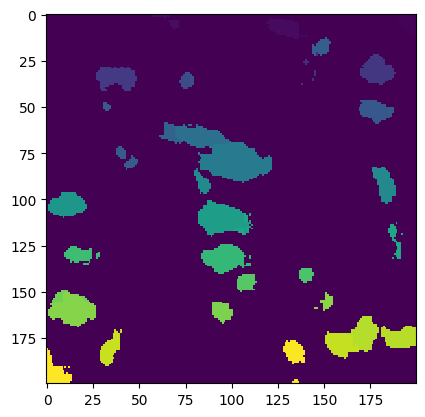

In [3]:
from funlib.geometry import Roi
import zarr
import mwatershed as mws
from funlib.segment.arrays import relabel, replace_values
from funlib.persistence import open_ds
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import measurements

# densely annotated validation region:
offset = np.array([27400, 2000, 5300])
dimensions = np.array([300, 200, 200])
zarr_file = zarr.open(f"/nrs/stern/em_data/jrc_22ak351-leaf-3m/jrc_22ak351-leaf-3m.n5", mode="r")
dataset = "em/fibsem-uint8/s0"
resolution = np.array(zarr_file[dataset].attrs.asdict()["transform"]["scale"])
validation_roi = Roi(offset[::-1]*resolution, dimensions[::-1]*resolution)

affs = open_ds("/nrs/cellmap/ackermand/predictions/jrc_22ak351-leaf-3m/jrc_22ak351-leaf-3m.n5","/predictions/2023-05-24/nuclearpores_affs_lsds/0__affs")
offsets = affs.data.attrs["affs_offsets"]
affs = open_ds("/groups/cellmap/cellmap/ackermand/Programming/nuclearpores_dacapo/temp.n5","pred")
#offsets = [offset[::-1] for offset in offsets]
#offsets=[offsets[i] for i in range(8,-1,-1)]
offsets = offsets[:]
affs = affs.intersect(validation_roi)
affs.materialize()
affs.data=affs.data[:9].astype(np.float64)

filter_fragments = 0.5
fragments_data = mws.agglom(
        affs.data - filter_fragments,# + shift + random_noise + smoothed_affs,
        offsets=offsets,
    )
prev_high_mean = 0
if filter_fragments > 0:
        average_affs = np.mean(affs.data, axis=0)

        filtered_fragments = []

        fragment_ids = np.unique(fragments_data)

        for fragment, mean in zip(
            fragment_ids, measurements.mean(average_affs, fragments_data, fragment_ids)
        ):
            if mean < filter_fragments:
                filtered_fragments.append(fragment)
            if mean>filter_fragments:
                #print(fragment,np.sum(fragments_data == fragment))
                prev_high_mean=mean

        filtered_fragments = np.array(filtered_fragments, dtype=fragments_data.dtype)
        replace = np.zeros_like(filtered_fragments)
        replace_values(fragments_data, filtered_fragments, replace, inplace=True)
plt.imshow(fragments_data[:,:,150],interpolation="none")


In [159]:
np.unique(fragments_data)

array([0], dtype=uint64)

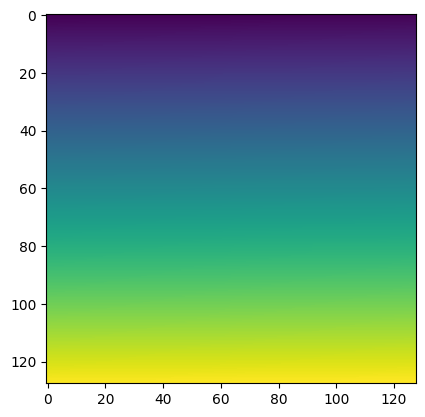

In [110]:
plt.imshow(fragments_data[:,:,120])

In [79]:
plt.imshow(affs.data[6,:,:,64])

IndexError: index 6 is out of bounds for axis 0 with size 6

In [6]:
from dacapo.store import create_array_store
array_store = create_array_store()
array_store.validation_input_arrays(run.name, validation_dataset.name)

(LocalArrayIdentifier(container=PosixPath('/nrs/cellmap/ackermand/cellmap_experiments/test/finetuned_3d_lsdaffs_plasmodesmata_upsample-unet_default_v2__0/validation.zarr'), dataset='inputs/val/raw'),
 LocalArrayIdentifier(container=PosixPath('/nrs/cellmap/ackermand/cellmap_experiments/test/finetuned_3d_lsdaffs_plasmodesmata_upsample-unet_default_v2__0/validation.zarr'), dataset='inputs/val/gt'))